<a href="https://colab.research.google.com/github/DrFrank25/MD-analysis/blob/main/Gyration_NMDA.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [7]:
# --- Script Radius Gyration with Savitzky–Golay smoothing ---
import numpy as np
import matplotlib.pyplot as plt
from google.colab import files
import pandas as pd
from scipy.signal import savgol_filter

In [8]:
# ===== Settings =====
SMOOTH_WINDOW = 11  # maximum smoothing window size (must be odd)
POLY_ORDER = 2      # polynomial order for Savitzky–Golay
COLORS = ['#1f77b4', '#ff7f0e', '#2ca02c', '#d62728', '#9467bd', '#8c564b', '#e377c2']
FIGSIZE = (11, 6)
DPI = 1200
# Legend names
LEGEND_NAMES = ["Run 1", "Run 2", "Run 3"]
# ====================

In [10]:
# File upload
uploaded = files.upload()
if not uploaded:
    raise SystemExit("No file uploaded. Please upload .xvg files.")



Saving gyrate_1.xvg to gyrate_1 (1).xvg
Saving gyrate_2.1.xvg to gyrate_2.1 (1).xvg
Saving gyrate_3.xvg to gyrate_3.xvg


In [11]:
# Function to read .xvg data
def read_xvg_from_bytes(content_bytes, encoding='utf-8'):
    s = content_bytes.decode(encoding, errors='replace')
    times, vals = [], []
    for line in s.splitlines():
        line = line.strip()
        if not line or line.startswith(('#', '@')):
            continue
        parts = line.split()
        if len(parts) >= 2:
            try:
                times.append(float(parts[0]))
                vals.append(float(parts[1]))
            except ValueError:
                continue
    return np.array(times), np.array(vals)

plt.figure(figsize=FIGSIZE)


<Figure size 1100x600 with 0 Axes>

<Figure size 1100x600 with 0 Axes>

Run 1:
  Mean: 2.94 nm
  Standard deviation: 0.0 nm

Run 2:
  Mean: 2.94 nm
  Standard deviation: 0.0 nm

Run 3:
  Mean: 2.93 nm
  Standard deviation: 0.0 nm



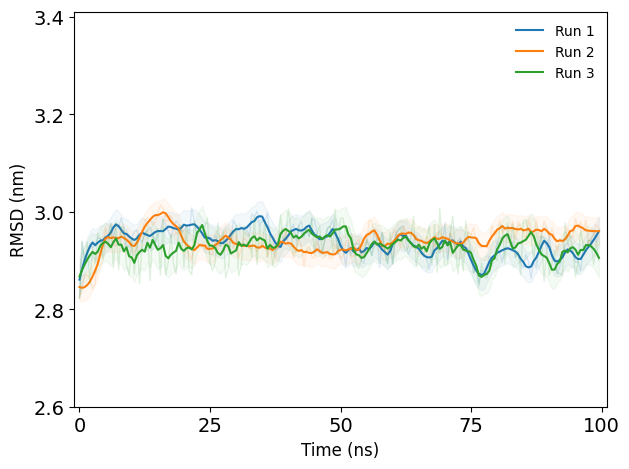

In [12]:
# Loop over uploaded files
for i, (name, content) in enumerate(uploaded.items()):
    time, rmsd = read_xvg_from_bytes(content)

    if time.size == 0 or rmsd.size == 0:
        print(f"Warning: '{name}' contains no valid data. Skipping.")
        continue

    # Sort by time
    order = np.argsort(time)
    time = time[order]
    rmsd = rmsd[order]

    # --- Interpolation to normalize the time axis ---
    # Define a common time axis (e.g., 0 up to max, step of 0.5 ns)
    common_time = np.arange(0, np.nanmax(time), 0.5)  # adjust step here

    # Interpolate only valid points
    mask_valid_interp = np.isfinite(time) & np.isfinite(rmsd)
    rmsd_interp = np.interp(common_time, time[mask_valid_interp], rmsd[mask_valid_interp])

    # Replace variables for the rest of the code
    time = common_time
    rmsd = rmsd_interp

    # Mask for valid data
    mask_valid = np.isfinite(time) & np.isfinite(rmsd) & (time >= 0) & (rmsd >= 0)
    valid_points = np.sum(mask_valid)

    # Window adjustment for small datasets
    window = min(SMOOTH_WINDOW, valid_points if valid_points > 3 else 1)
    if window % 2 == 0:
        window = max(5, window - 1)  # window must be odd

    time_masked = np.where(mask_valid, time, np.nan)
    rmsd_masked = np.where(mask_valid, rmsd, np.nan)

    mean_val = np.nanmean(rmsd_masked)
    std_val = np.nanstd(rmsd_masked)

    # Savitzky–Golay smoothing
    if valid_points >= 3 and window > POLY_ORDER:
        smooth_valid = savgol_filter(
            rmsd_masked[mask_valid],
            window_length=window,
            polyorder=POLY_ORDER,
            mode='interp'
        )
        smooth = np.full_like(rmsd_masked, np.nan)
        smooth[mask_valid] = smooth_valid
    else:
        smooth = rmsd_masked.copy()

    color = COLORS[i % len(COLORS)]

    # Curve name for legend
    curve_name = LEGEND_NAMES[i] if i < len(LEGEND_NAMES) else f"Run {i+1}"

    # Raw curve
    valid_raw = np.isfinite(time_masked) & np.isfinite(rmsd_masked)
    plt.plot(time_masked[valid_raw], rmsd_masked[valid_raw],
             linewidth=1.0, alpha=0.15, color=color)

    # Smoothed curve
    valid_smooth = np.isfinite(time_masked) & np.isfinite(smooth)
    plt.plot(time_masked[valid_smooth], smooth[valid_smooth],
             label=f"{curve_name}")

    # ± standard deviation band
    low = smooth[valid_smooth] + std_val
    high = smooth[valid_smooth] - std_val
    plt.fill_between(time_masked[valid_smooth], low, high, alpha=0.05, color=color)

    print(f"{curve_name}:")
    print(f"  Mean: {mean_val:.2f} nm")
    print(f"  Standard deviation: {std_val:.1f} nm\n")

    # Axes configuration
    plt.xlabel("Time (ns)", fontsize=12)
    plt.ylabel("RMSD (nm)", fontsize=12)
    plt.tick_params(axis='both', which='major', labelsize=14)


    # Ticks range
    plt.xlim(-1, 101)  # X-axis limits
    plt.ylim(2.6, 3.41)  # Y-axis limits
    plt.xticks(np.arange(0, 101, 25))      # from 0 to 100, step 25
    plt.yticks(np.arange(2.6, 3.41, 0.2))  # from 0 to 1.2, step 0.2

    # Desired run names
    run_names = ["Run 1", "Run 2", "Run 3"]

# Custom legend
plt.legend(
    loc='upper right',
    fontsize=10,
    frameon=True,
    facecolor='white',
    edgecolor='white',
    fancybox=False,
    shadow=False
)

plt.grid(False)
plt.tight_layout()

# --- Save and render the figure (at the end of the script, BEFORE plt.show()) ---
fig = plt.gcf()  # get the current figure (the one just plotted)
fig.tight_layout()
fig.canvas.draw()  # force rendering in Colab

In [17]:
# Save figure in high resolution with a specific name
fig.savefig(
    "gyration_NMDA.png",
    dpi=1200,
    bbox_inches='tight',
    transparent=False  # change to False if you prefer a solid background
)

plt.show()

from google.colab import files
files.download("gyration_NMDA.png")

<IPython.core.display.Javascript object>

<IPython.core.display.Javascript object>

In [15]:
# ======================
# Overall mean of the 3 runs (raw values)
# ======================

# === Global statistics with raw data (from uploaded files) ===
all_values = []

for name, content in uploaded.items():
    time, rmsd = read_xvg_from_bytes(content)
    mask_valid = np.isfinite(rmsd) & (rmsd >= 0)
    if np.any(mask_valid):
        all_values.extend(rmsd[mask_valid])

all_values = np.array(all_values)

global_mean = np.mean(all_values)
global_std = np.std(all_values)

print("\n=== Global mean statistics (raw data) ===")
print(f"Global mean: {global_mean:.4f} nm")
print(f"Global standard deviation: {global_std:.4f} nm")#


=== Global mean statistics (raw data) ===
Global mean: 2.9348 nm
Global standard deviation: 0.0350 nm
